<p align="center">
  <img src="https://indicium.ai/wp-content/uploads/2025/03/Logo-white-word-mark.png" alt="Indicium" width="200">
</p>


# Case Técnico - Indicium - EDA
---
Olá, **me chamo Felipe** e estou apresentando minha análise para o **Desafio Cientista de Dados** da Indicium.  
Neste Notebook eu mostro a **Exploratory Data Analysis (EDA)** dos dados ofertados, buscando compreender sua estrutura e extrair possíveis insights para a modelagem.

---

## Objetivo da análise (o que eu busco)
- Entender as características dos filmes no dataset (duração, gênero, elenco, diretor, faturamento, críticas, etc.).  
- Gerar insights acionáveis para orientar a tomada de decisão sobre qual tipo de filme a PProductions deve desenvolver.  

---

## O que será apresentado
1. **Visão geral da base** — tamanho, tipos de variáveis e qualidade dos dados.  
2. **Limpeza e transformações** — como tratei `Runtime`, `Gross`, `Released_Year`, faltantes e categorias raras.  
3. **Distribuições e correlações** — principais padrões e transformações sugeridas (ex.: `log1p` para variáveis enviesadas).  
4. **Análise de texto (Overview)** — palavras-chave, possíveis sinais de gênero e relação com sucesso crítico/comercial.  

---
**Nota importante**: nesta análise exploratória **não irei realizar imputação ou tratamento final dos dados**.  
O objetivo é **mapear a base, identificar padrões, limitações e potenciais ajustes**, para então desenhar um **pipeline estruturado** a partir do que foi aprendido aqui.  

---

Resposta as perguntas:

2- a) The Godfather, pois tem a melhor nota IMDB e meta_score

b) Usando como base nosso dataset, por correlação, teriamos Numero de votos e Ano de lançamento, além de atores conhecidos e Diretores renomados.

c) A coluna Overview permite extrair palavras-chave e sentimentos, ajudando a inferir gênero. Isso pode ser feito usando PLN, identificando palavras chaves relacionadas ao gênero e sentimentos.

(Outras respostas podem ser encontradas no outro notebook)

In [34]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
#Aqui defino algumas funções que serão utilizadas durante o notebook
# 1- display_info faz jus ao nome para apresentar os dados e suas métricas 
# 2- add_labels_inside foi desenvolvida para plotar alguns dados de maneira mais estruturada e é usada ativamente posteriormente.
# 3- plot_bar_counts não foi tão usada mas senti a necessidade de cria-la para poupar código de plotagem
def display_info (df, nome):
    print("\n"+"-"*30 + f"{nome}" + "-"*30)
    print(df.info())
    print("\n"+"-"*10 + f"DESCRICAO:")
    display(df.describe().round(2))
    display(df.describe(include=['object']).T)
    print("\n"+"-"*10 + f"VALORES NULOS:\n{df.isnull().sum()}\nLINHAS COM NULOS:"+"-"*10+f"HEAD TABELA: {nome}")
    display(df.head())

def add_labels_inside(ax, fmt="{:.0f}"):
    for p in ax.patches:
        value = p.get_width()
        ax.text(
            p.get_x() + value/2,           # meio da barra
            p.get_y() + p.get_height()/2,  #centralizado vertical
            fmt.format(value),
            ha="center", va="center",
            color="white", fontsize=9, fontweight="bold"
        )

def plot_bar_counts(series, title="", color="skyblue", highlight_top=True, figsize=(12,6)):
    counts = series.value_counts()
    plt.figure(figsize=figsize)
    bars = sns.barplot(x=counts.index, y=counts.values, color=color)
    
    # Descobrir índice do maior
    top_idx = 0
    
    for i, bar in enumerate(bars.patches):
        if highlight_top and i == top_idx:
            bar.set_alpha(1)
        else:
            bar.set_alpha(0.7)
        
        #Valores em cima da barra
        height = bar.get_height()
        bars.text(
            bar.get_x() + bar.get_width()/2,
            height + counts.max()*0.01,
            f"{int(height)}",
            ha="center", va="bottom", fontsize=9, fontweight="bold"
        )
    
    plt.xticks(rotation=45, ha="right")
    plt.title(title)
    plt.xlabel(series.name)
    plt.ylabel("Contagem")
    plt.tight_layout()
    plt.show()



### Importação e reconhecimento dos dados
---

- Nesta etapa, utilizo a função `display_info()` para obter uma visão geral do dataset **Dados PProductions**.  
- A partir do resultado, já conseguimos levantar hipóteses importantes para a construção do pipeline.  

---

#### Principais observações
- **Formato da base**: 999 registros e 15 colunas.  
- **Tipos de variáveis**: predominância de `object` (categóricas e textuais), além de variáveis numéricas (`float64` e `int64`).  
- **Valores ausentes**: destaque para `Certificate` (101 nulos), `Meta_score` (157 nulos) e `Gross` (169 nulos).  
- **Colunas críticas a tratar**:  
  - `Released_Year` → atualmente como `object`, precisa ser convertida para numérica.  
  - `Runtime` → armazenada como string (`"175 min"`), deve ser transformada em minutos inteiros.  
  - `Gross` → numérica armazenada como texto, requer limpeza e conversão.  
- **Distribuições iniciais**:  
  - `IMDB_Rating` apresenta baixa variabilidade (média ~8.0, desvio-padrão 0.27).  
  - `No_of_Votes` é altamente disperso (máximo acima de 2,3M votos).  
  - `Meta_score` varia entre 28 e 100, com leve concentração em torno de 70–80.  
- **Alta cardinalidade** em algumas colunas categóricas, como `Director` (548 valores únicos) e `Genre` (202 combinações).  

---

#### Implicações para o pipeline
Com base nessas observações, já podemos prever que o pipeline precisará contemplar:  

a. **Transformação de tipo** - conversão de `Released_Year`, `Runtime` e `Gross`.  
b. **Inputação de valores faltantes** - especialmente em `Certificate`, `Meta_score` e `Gross`.  
c. **Normalização/transformações estatísticas** - aplicar `log1p` ou escalonamento para lidar com distribuições enviesadas (ex.: `No_of_Votes`, `Gross`).

In [36]:
dados = pd.read_csv("./data/desafio_indicium_imdb.csv")

dados = dados.drop("Unnamed: 0", axis=1)

display_info(dados, "Dados PProductions")


------------------------------Dados PProductions------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    object 
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    object 
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    object 
dtypes: float64(2), int64(1), object(12)
memory usage: 117.2+ KB
No

,IMDB_Rating,Meta_score,No_of_Votes
count,999.00,842.00,999.00
mean,7.95,77.97,271621.42
std,0.27,12.38,320912.62
min,7.60,28.00,25088.00
25%,7.70,70.00,55471.50
50%,7.90,79.00,138356.00
75%,8.10,87.00,373167.50
max,9.20,100.00,2303232.00


,count,unique,top,freq
Series_Title,999,998,Drishyam,2
Released_Year,999,100,2014,32
Certificate,898,16,U,234
Runtime,999,140,130 min,23
Genre,999,202,Drama,84
Overview,999,999,An organized crime dynasty's aging patriarch t...,1
Director,999,548,Alfred Hitchcock,14
Star1,999,659,Tom Hanks,12
Star2,999,840,Emma Watson,7
Star3,999,890,Rupert Grint,5



----------VALORES NULOS:
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64
LINHAS COM NULOS:----------HEAD TABELA: Dados PProductions


,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


### Explorando a coluna Released_year, Runtime e Gross
---
- Minha intenção principal é conseguir transformar essas colunas em numéricas para padronizar nosso dataset.
- Vamos precisar adicionar esse passo no pipeline do modelo

In [37]:
#EXPLORANDO A COLUNA RELEASED_YEAR POIS QUERO TRANSFORMA-LA EM TYPE INT
print(dados["Released_Year"].unique())
#Localizando o valor diferente e substituindo pelo correto presente no site da IMDB
display(dados[dados["Released_Year"]=='PG'])
dados.loc[dados["Released_Year"] == "PG", "Released_Year"] = "1995"

dados["Released_Year"] = pd.to_numeric(dados["Released_Year"], errors="coerce")

dados[dados["Series_Title"]== "Apollo 13"]

['1972' '2008' '1974' '1957' '2003' '1994' '1993' '2010' '1999' '2001'
 '1966' '2002' '1990' '1980' '1975' '2020' '2019' '2014' '1998' '1997'
 '1995' '1991' '1977' '1962' '1954' '1946' '2011' '2006' '2000' '1988'
 '1985' '1968' '1960' '1942' '1936' '1931' '2018' '2017' '2016' '2012'
 '2009' '2007' '1984' '1981' '1979' '1971' '1963' '1964' '1950' '1940'
 '2013' '2005' '2004' '1992' '1987' '1986' '1983' '1976' '1973' '1965'
 '1959' '1958' '1952' '1948' '1944' '1941' '1927' '1921' '2015' '1996'
 '1989' '1978' '1961' '1955' '1953' '1925' '1924' '1982' '1967' '1951'
 '1949' '1939' '1937' '1934' '1928' '1926' '1920' '1970' '1969' '1956'
 '1947' '1945' '1930' '1938' '1935' '1933' '1932' '1922' '1943' 'PG']


,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
965,Apollo 13,PG,U,140 min,"Adventure, Drama, History",7.6,NASA must devise a strategy to return Apollo 1...,77.0,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197,"173,837,933"


,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
965,Apollo 13,1995,U,140 min,"Adventure, Drama, History",7.6,NASA must devise a strategy to return Apollo 1...,77.0,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197,"173,837,933"


In [38]:
# EXPLORANDO A COLUNA RUNTIME POIS QUERO TRANSFORMA-LA EM TYPE INT
print(dados["Runtime"].unique())
# Extraindo texto de min e transformando em int
dados["Runtime"] = dados["Runtime"].str.extract(r"(\d+)")
dados["Runtime"] = pd.to_numeric(dados["Runtime"], errors="coerce").astype("Int64")
# Renomeando pra não ficar confuso
dados.rename(columns={"Runtime": "Runtime_Min"}, inplace=True)

display(dados.head(1))

['175 min' '152 min' '202 min' '96 min' '201 min' '154 min' '195 min'
 '148 min' '139 min' '178 min' '142 min' '161 min' '179 min' '136 min'
 '146 min' '124 min' '133 min' '160 min' '132 min' '153 min' '169 min'
 '130 min' '125 min' '189 min' '116 min' '127 min' '118 min' '121 min'
 '207 min' '122 min' '106 min' '112 min' '151 min' '150 min' '155 min'
 '119 min' '110 min' '88 min' '137 min' '89 min' '165 min' '109 min'
 '102 min' '87 min' '126 min' '147 min' '117 min' '181 min' '149 min'
 '105 min' '164 min' '170 min' '98 min' '101 min' '113 min' '134 min'
 '229 min' '115 min' '143 min' '95 min' '104 min' '123 min' '131 min'
 '108 min' '81 min' '99 min' '114 min' '129 min' '228 min' '128 min'
 '103 min' '107 min' '68 min' '138 min' '156 min' '167 min' '163 min'
 '186 min' '321 min' '135 min' '140 min' '180 min' '158 min' '210 min'
 '86 min' '162 min' '177 min' '204 min' '91 min' '172 min' '45 min'
 '145 min' '100 min' '196 min' '93 min' '120 min' '92 min' '144 min'
 '80 min' '183 min' 

,Series_Title,Released_Year,Certificate,Runtime_Min,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"


In [39]:
# TRANSFORMANDO A COLUNA GROSS PARA FLOAT, 

dados["Gross"] = dados["Gross"].str.replace(",", "", regex=False) #como vem como texto e o separador é "," estou so tirando

dados["Gross"] = pd.to_numeric(dados["Gross"], errors="coerce")


In [40]:
#df apos transformações
display(dados.head())

,Series_Title,Released_Year,Certificate,Runtime_Min,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
1,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
2,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
3,12 Angry Men,1957,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0
4,The Lord of the Rings: The Return of the King,2003,U,201,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.0


### Compreendendo as colunas com Nan
---
- Durante esse processo quis descobrir o conteudo dos nossos registros com Nan e compreender possíveis motivos.
- Podemos ver que existem anos que não possuem Gross.


In [41]:
dados[dados["Meta_score"].isna()==True].head()

,Series_Title,Released_Year,Certificate,Runtime_Min,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
19,Soorarai Pottru,2020,U,153,Drama,8.6,"Nedumaaran Rajangam ""Maara"" sets out to make t...",NaN,Sudha Kongara,Suriya,Madhavan,Paresh Rawal,Aparna Balamurali,54995,NaN
53,Ayla: The Daughter of War,2017,NaN,125,"Biography, Drama, History",8.4,"In 1950, amid-st the ravages of the Korean War...",NaN,Can Ulkay,Erdem Can,Çetin Tekindor,Ismail Hacioglu,Kyung-jin Lee,34112,NaN
54,Vikram Vedha,2017,UA,147,"Action, Crime, Drama",8.4,"Vikram, a no-nonsense police officer, accompan...",NaN,Gayatri,Pushkar,Madhavan,Vijay Sethupathi,Shraddha Srinath,28401,NaN
56,Dangal,2016,U,161,"Action, Biography, Drama",8.4,Former wrestler Mahavir Singh Phogat and his t...,NaN,Nitesh Tiwari,Aamir Khan,Sakshi Tanwar,Fatima Sana Shaikh,Sanya Malhotra,156479,12391761.0
64,Taare Zameen Par,2007,U,165,"Drama, Family",8.4,An eight-year-old boy is thought to be a lazy ...,NaN,Aamir Khan,Amole Gupte,Darsheel Safary,Aamir Khan,Tisca Chopra,168895,1223869.0


In [42]:
dados["Certificate"] = dados["Certificate"].fillna("Missing")

#dados["Meta_missing"] = dados["Meta_score"].isna().astype(int) Processos de imputação vou deixar para o pipeline
#dados["Meta_score"] = dados["Meta_score"].fillna(dados["Meta_score"].median()) 

anos_com_gross_nulo = dados.groupby("Released_Year")["Gross"].apply(lambda x: x.isna().all())

#interessante observar os anos mais antigos com gross nulo, cabe até mesmo investigar se a quebra da bolsa de
#NY influenciou nessa falta de registro.
#2020 já temos no imaginario coletivo um bom pq (ou talvez seja apenas por ser o ultimo ano)
print(anos_com_gross_nulo[anos_com_gross_nulo])



Released_Year
1920    True
1922    True
1932    True
1943    True
2020    True
Name: Gross, dtype: bool


### Criação da coluna Decade e informações padronizadas do DF
---
- Aqui estou apenas preparando o terreno para começar com alguns plots, criei a coluna decade pois queria identificar possiveis outliers.


In [81]:
#intervalo de 10 anos - quero ver os outliers
dados["Decade"] = ((dados["Released_Year"] // 10) * 10).astype("Int64")

# Coluna indicador de valor nulo - tinha feito para todas as faltantes mas tb não coloquei no pipe
#dados["Gross_missing"] = dados["Gross"].isna().astype(int)

# preencher Gross com a mediana da década foi uma ideia que tive, mas não concretizei no pipe
#dados["Gross"] = dados.groupby("Decade")["Gross"].transform(lambda x: x.fillna(x.median()))

# Preencher valores restantes com mediana geral (fallback)
#dados["Gross"] = dados["Gross"].fillna(dados["Gross"].median())


In [82]:
display_info(dados, "tratados")


------------------------------tratados------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    int64  
 2   Certificate    999 non-null    object 
 3   Runtime_Min    999 non-null    Int64  
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    float64
 15  Decade         999 non-null    Int64  
dtypes: Int64(2), float64(3), int

,Released_Year,Runtime_Min,IMDB_Rating,Meta_score,No_of_Votes,Gross,Decade
count,999.00,999.0,999.00,842.00,999.00,8.300000e+02,999.0
mean,1991.22,122.87,7.95,77.97,271621.42,6.808257e+07,1986.59
std,23.30,28.1,0.27,12.38,320912.62,1.098076e+08,23.19
min,1920.00,45.0,7.60,28.00,25088.00,1.305000e+03,1920.0
25%,1976.00,103.0,7.70,70.00,55471.50,3.245338e+06,1970.0
50%,1999.00,119.0,7.90,79.00,138356.00,2.345744e+07,1990.0
75%,2009.00,137.0,8.10,87.00,373167.50,8.087634e+07,2000.0
max,2020.00,321.0,9.20,100.00,2303232.00,9.366622e+08,2020.0


,count,unique,top,freq
Series_Title,999,998,Drishyam,2
Certificate,999,17,U,234
Genre,999,202,Drama,84
Overview,999,999,An organized crime dynasty's aging patriarch t...,1
Director,999,548,Alfred Hitchcock,14
Star1,999,659,Tom Hanks,12
Star2,999,840,Emma Watson,7
Star3,999,890,Rupert Grint,5
Star4,999,938,Michael Caine,4



----------VALORES NULOS:
Series_Title       0
Released_Year      0
Certificate        0
Runtime_Min        0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
Decade             0
dtype: int64
LINHAS COM NULOS:----------HEAD TABELA: tratados


,Series_Title,Released_Year,Certificate,Runtime_Min,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Decade
0,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,1970
1,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0,2000
2,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0,1970
3,12 Angry Men,1957,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0,1950
4,The Lord of the Rings: The Return of the King,2003,U,201,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.0,2000


## Visualizar para compreender
---
- Nessa seção, vamos explorar visualmente alguns aspectos dos nossos dados. Buscando compreender suas distribuições, evoluções ao longo do tempo, outliers e correlações.
---
### 1. Released_Year
- A quantidade de filmes cresce gradualmente ao longo do tempo, com um **pico após 2000**.
- Isso indica um **aumento na produção de filmes recentes**, possivelmente pelo crescimento da indústria cinematográfica e acesso a novas tecnologias.

### 2. Runtime_Min
- Distribuição próxima de normal, centrada em torno de **100–120 minutos**.
- Filmes muito curtos (< 60 min) e muito longos (> 200 min) são **raros** (outliers).
- Reforça o padrão de mercado de filmes com duração em torno de 2 horas.

### 3. IMDB_Rating
- Distribuição concentrada entre **7.5 e 8.5**, com cauda à direita.
- A maioria dos filmes do dataset são **bem avaliados**.
- Notas acima de 9 são **raras e excepcionais**.

### 4. Meta_score
- Leve assimetria à esquerda, com maior concentração entre **60 e 90**.
- A maioria dos filmes recebe avaliação **boa a muito boa** pela crítica.
- Poucos filmes têm notas baixas (< 40).

### 5. No_of_Votes
- Distribuição altamente **assimétrica (cauda longa à direita)**.
- Poucos filmes concentram uma **quantidade massiva de votos**, enquanto a maioria recebe poucos.
- Indica **alta popularidade concentrada** em alguns títulos.

### 6. Gross
- Também apresenta forte **assimetria à direita**.
- A maior parte dos filmes arrecada pouco, mas alguns têm arrecadações muito altas.
- Sugere uma **distribuição desigual de bilheteria**, com poucos blockbusters dominando o mercado.


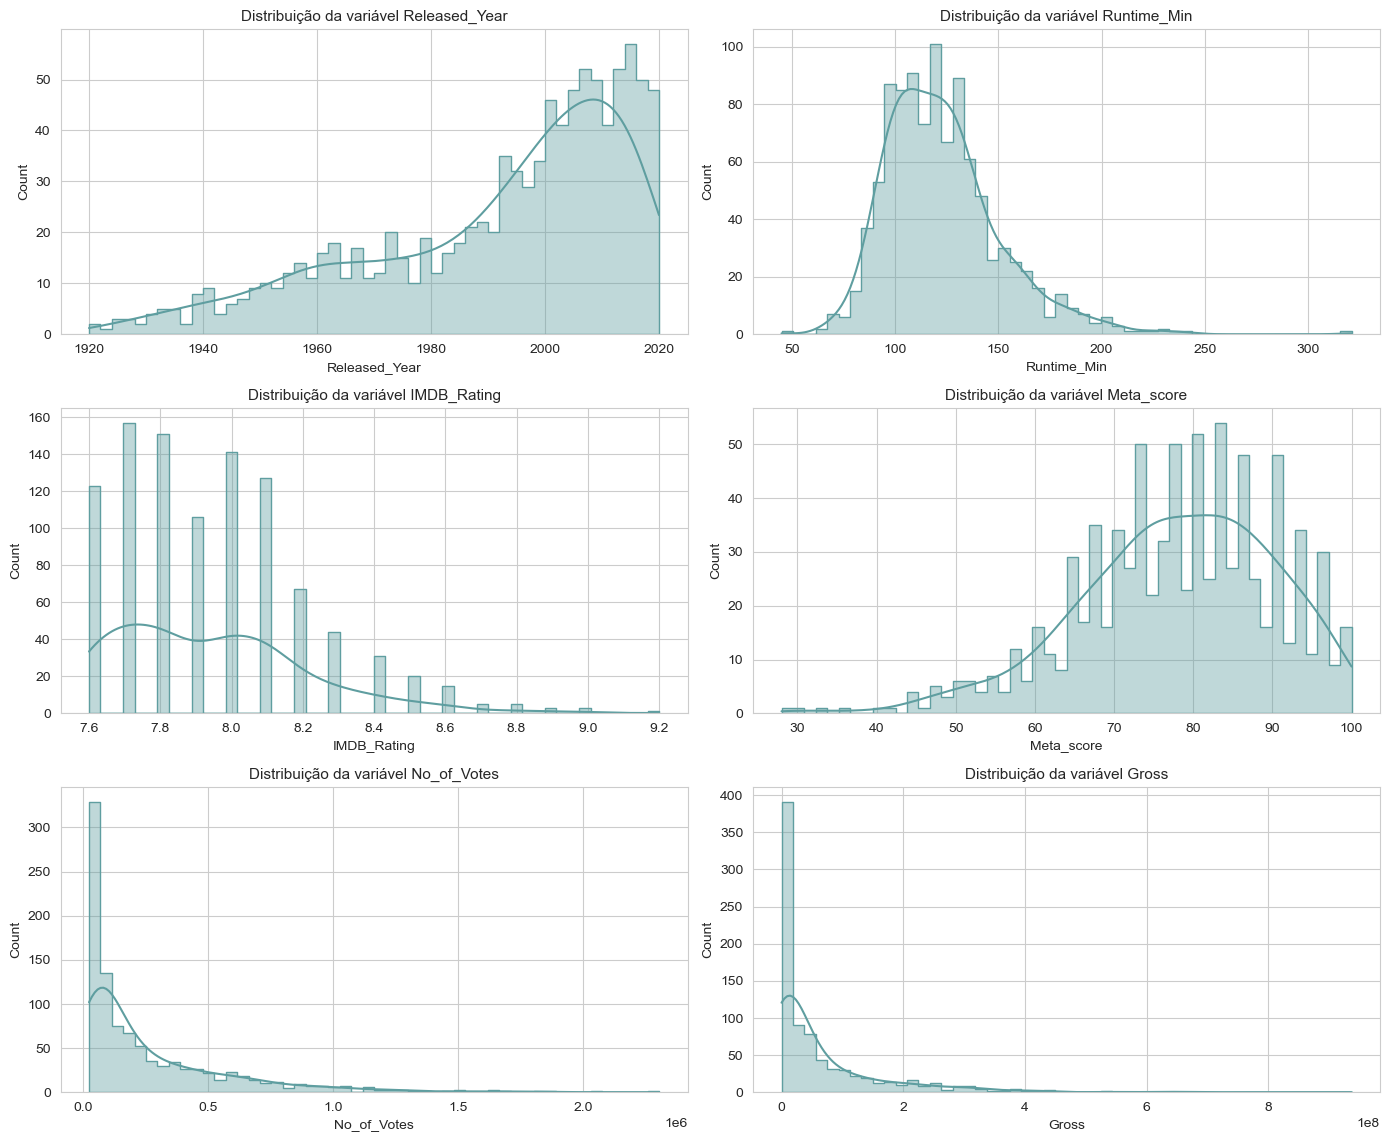

In [83]:
numericas = ["Released_Year", "Runtime_Min", "IMDB_Rating", "Meta_score", "No_of_Votes", "Gross"]

plt.figure(figsize=(14,12))

for i, col in enumerate(numericas, start=1):
    plt.subplot(3, 2, i)
    sns.histplot(data=dados, x=col, bins=50, kde=True, color = "cadetblue", alpha=0.4, element="step")
    plt.title(f"Distribuição da variável {col}", fontsize=11)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### COMO ESTÃO OS DADOS NO TEMPO?
---
- Aqui so vou tentar ver como os dados estão distribuidos pelos anos e ver se a imputação afeta muito a série temporal.

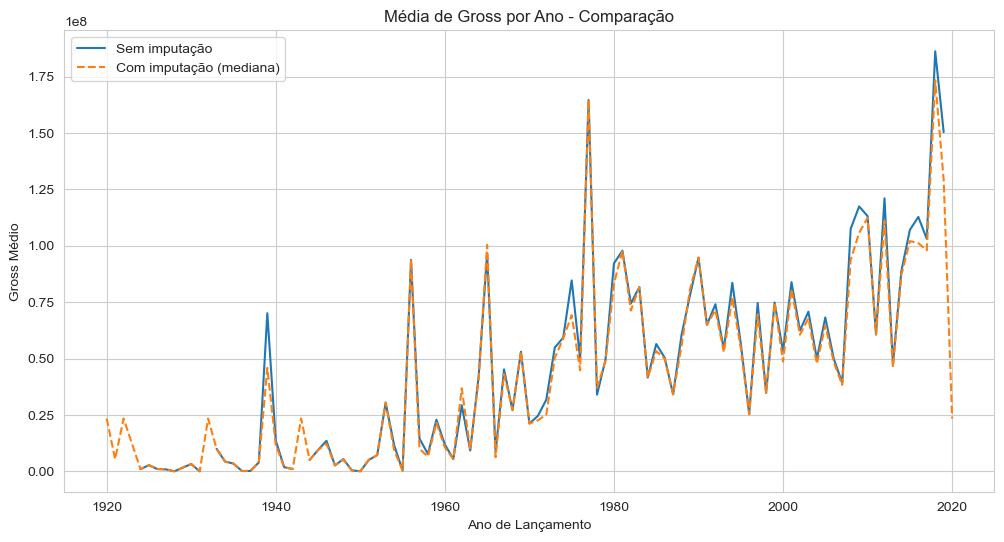

In [88]:
#COMO FICARIA NOSSA SÉRIE COM A IMPUTAÇÃO DOS DADOS?
dados_imp = dados.copy()
dados_imp["Gross"] = dados_imp["Gross"].fillna(
    dados_imp.groupby("Released_Year")["Gross"].transform("median")
).fillna(dados["Gross"].median())

media_original = dados.groupby("Released_Year")["Gross"].mean()
media_imputada = dados_imp.groupby("Released_Year")["Gross"].mean()

plt.figure(figsize=(12,6))
plt.plot(media_original.index, media_original.values, label="Sem imputação")
plt.plot(media_imputada.index, media_imputada.values, label="Com imputação (mediana)", linestyle="--")
plt.title("Média de Gross por Ano - Comparação")
plt.xlabel("Ano de Lançamento")
plt.ylabel("Gross Médio")
plt.legend()
plt.show()


<Axes: xlabel='Released_Year'>

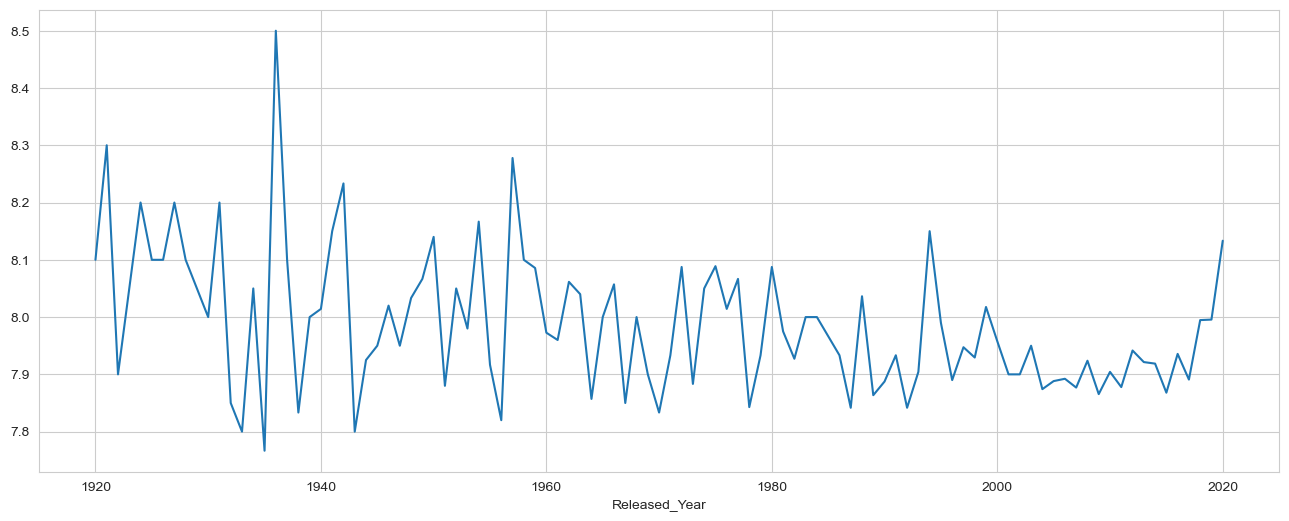

In [93]:
#PODEMOS OBSERVAR PICOS INTERESSANTES ANTES DE 1940 E UMA "PADRONIZAÇÃO"/ASCENÇÃO DOS ANOS 2000-2020
dados.groupby('Released_Year')['IMDB_Rating'].mean().plot()

### Principais Inferências boxplot por decada
---

1. **Estabilidade das Medianas**
   - As medianas dos `IMDB_Rating` se mantêm próximas de **8** em quase todas as décadas.
   - Isso sugere uma consistência na qualidade média dos filmes considerados na base.

2. **Aumento da Dispersão ao Longo do Tempo**
   - Nas décadas mais recentes (2000, 2010 e 2020) observa-se uma **maior variação** nas notas.
   - Isso indica maior diversidade de produções, com filmes tanto muito bem avaliados quanto medianos.

3. **Presença de OutlieQuase ts**
   - Todas as décadas apresentam filmes considerados **fora do padrão** (outliers).
   - D5caeas de 197  têm vários filmes com notas **acima de 9**, que podem ser considerados clássicos.

4. **Década de 2020**
   - Possui menos dados (período ainda em andamento).
   - Mostra **mediana levemente menor**, mas com cauda superior maior, sugerindo alguns filmes de destaque.

5. **Décadas Antigas (1920–1950)**
   - Apresentam caixas mais compactas (menor variação).
   - Isso pode refletir a **quantidade reduzida de filmes na base** ou um viés de seleção (apenas clássicos preservados).


<Axes: xlabel='Decade', ylabel='IMDB_Rating'>

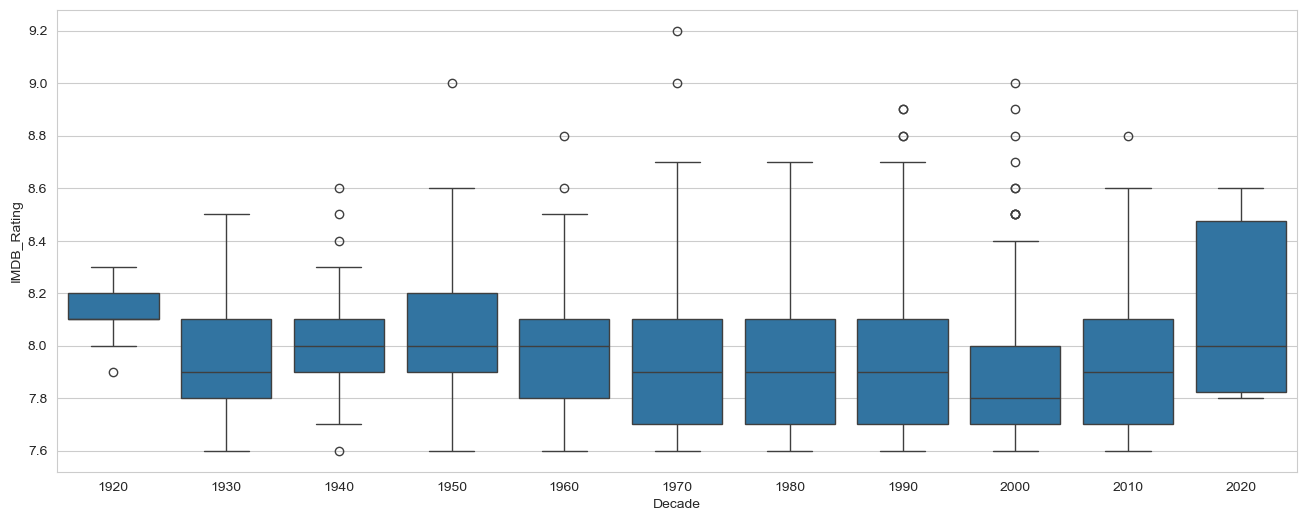

In [48]:
#OUTLIERS
sns.boxplot(x='Decade', y='IMDB_Rating', data=dados)

### O que fazer com a coluna Gênero?
---
- Tantos gêneros, tanta diversidade, tantas colunas... A explosão de dimensionalidade é algo que sempre me deixa em alerta e mesmo quando tomo cuidado acabo deixando acontecer.
- Vamos "explodir" essa coluna e avaliar os generos individualmente.
- Vamos testar o modelo com as colunas de genero e sem também, mas isso vai ficar pro pipeline!
- O genero mais presente é o **Drama**, afinal, quem não gosta de um bom filme de drama não é?
- As notas médias de IMBD por gênero não são tão variantes, mas sempre temos um que se destaca. E, nesse caso, são os filmes de **Guerra**

In [49]:
print(dados["Genre"].unique())#vamos ver uma lista gigante de uma mistura de generos
#podemos criar uma coluna binária para cada genero e caso o filme seja de tal genero a linha é preenchida com 1
#Esse processamento sera feito dentro do pipeline do modelo.



['Crime, Drama' 'Action, Crime, Drama' 'Action, Adventure, Drama'
 'Biography, Drama, History' 'Action, Adventure, Sci-Fi' 'Drama'
 'Drama, Romance' 'Western' 'Action, Sci-Fi' 'Biography, Crime, Drama'
 'Action, Adventure, Fantasy' 'Comedy, Drama, Thriller'
 'Adventure, Drama, Sci-Fi' 'Animation, Adventure, Family' 'Drama, War'
 'Crime, Drama, Fantasy' 'Comedy, Drama, Romance' 'Crime, Drama, Mystery'
 'Crime, Drama, Thriller' 'Action, Drama, Mystery'
 'Drama, Family, Fantasy' 'Drama, Music' 'Biography, Comedy, Drama'
 'Drama, Mystery, Sci-Fi' 'Biography, Drama, Music'
 'Crime, Mystery, Thriller' 'Animation, Adventure, Drama'
 'Animation, Drama, War' 'Adventure, Comedy, Sci-Fi'
 'Horror, Mystery, Thriller' 'Drama, Romance, War' 'Comedy, Drama, Family'
 'Animation, Drama, Fantasy' 'Action, Biography, Drama'
 'Animation, Action, Adventure' 'Drama, Western' 'Action, Adventure'
 'Comedy, Drama' 'Drama, Family' 'Drama, Mystery, Thriller'
 'Mystery, Thriller' 'Drama, Horror' 'Drama, Mystery, 

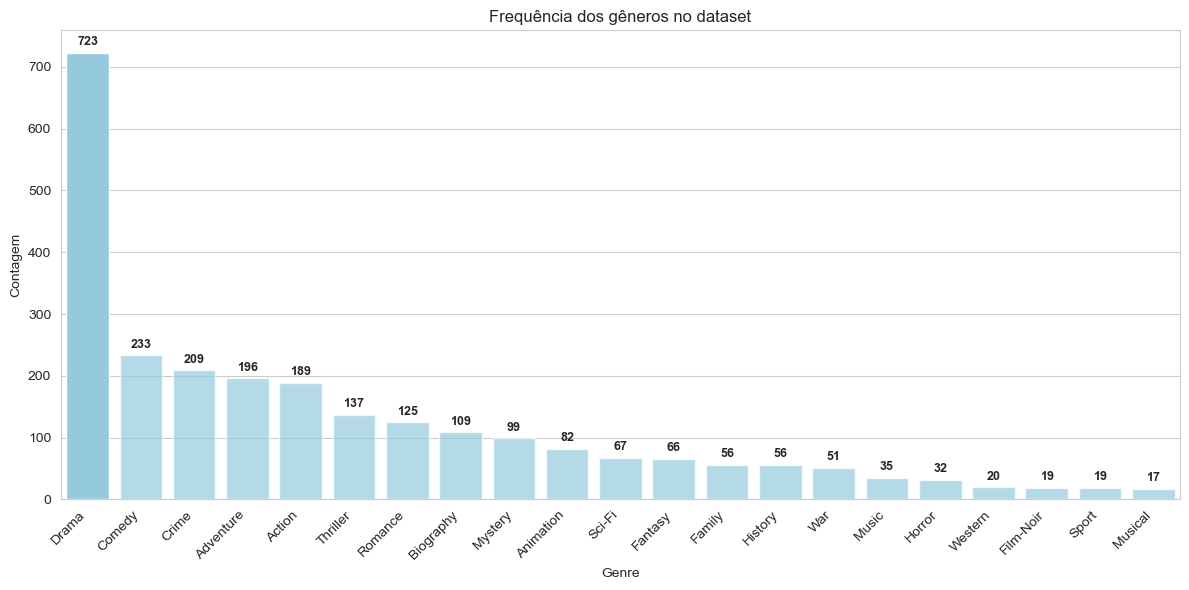

In [67]:
plot_bar_counts(dados['Genre'].str.split(", ").explode(), title="Frequência dos gêneros no dataset")

In [51]:
df_exp = dados.copy()
df_exp = df_exp.assign(Genre=df_exp['Genre'].str.split(', ')).explode('Genre')
df_exp.groupby('Genre')['IMDB_Rating'].mean().sort_values(ascending=False)


Genre
War          8.013725
Western      8.000000
Film-Noir    7.989474
Sci-Fi       7.977612
Mystery      7.967677
Drama        7.957538
Crime        7.954545
History      7.953571
Adventure    7.952041
Action       7.948677
Musical      7.947059
Biography    7.935780
Fantasy      7.931818
Animation    7.930488
Sport        7.926316
Romance      7.925600
Music        7.914286
Family       7.912500
Thriller     7.909489
Comedy       7.903433
Horror       7.887500
Name: IMDB_Rating, dtype: float64

### Proibido menores de 18!
---
- Certificate, apesar de também ser bem variado, não possui tamanha diversidade quanto gênero, e temos valores que mal aparecem (será que eles deveriam entrar no one-hot encoding?)

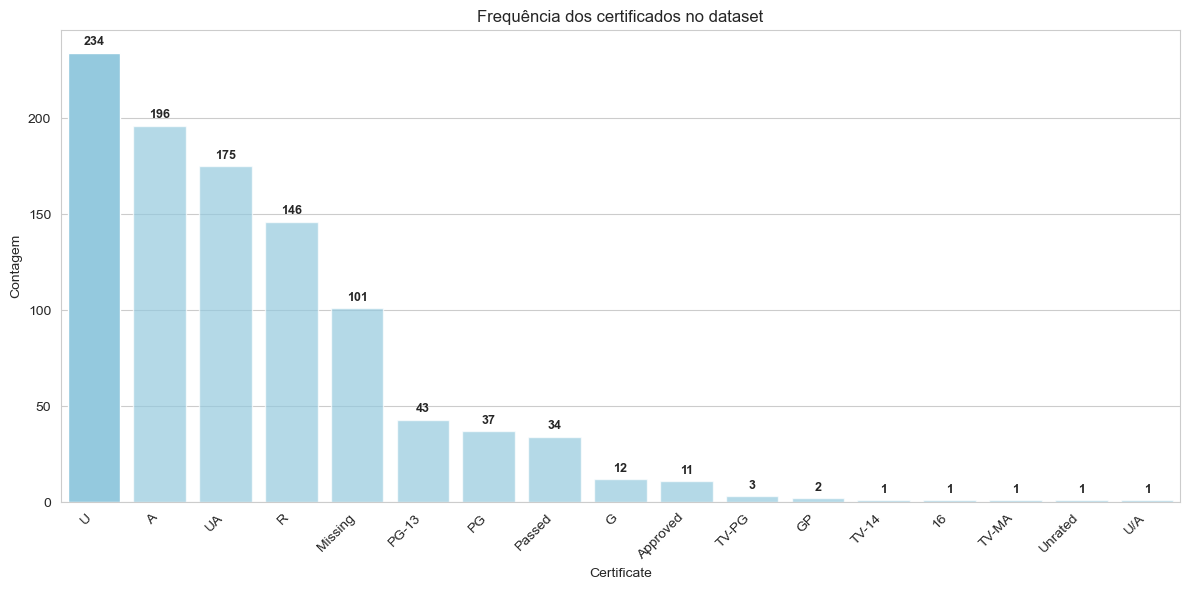

In [68]:
plot_bar_counts(dados['Certificate'], title="Frequência dos certificados no dataset")

<Axes: xlabel='Certificate', ylabel='IMDB_Rating'>

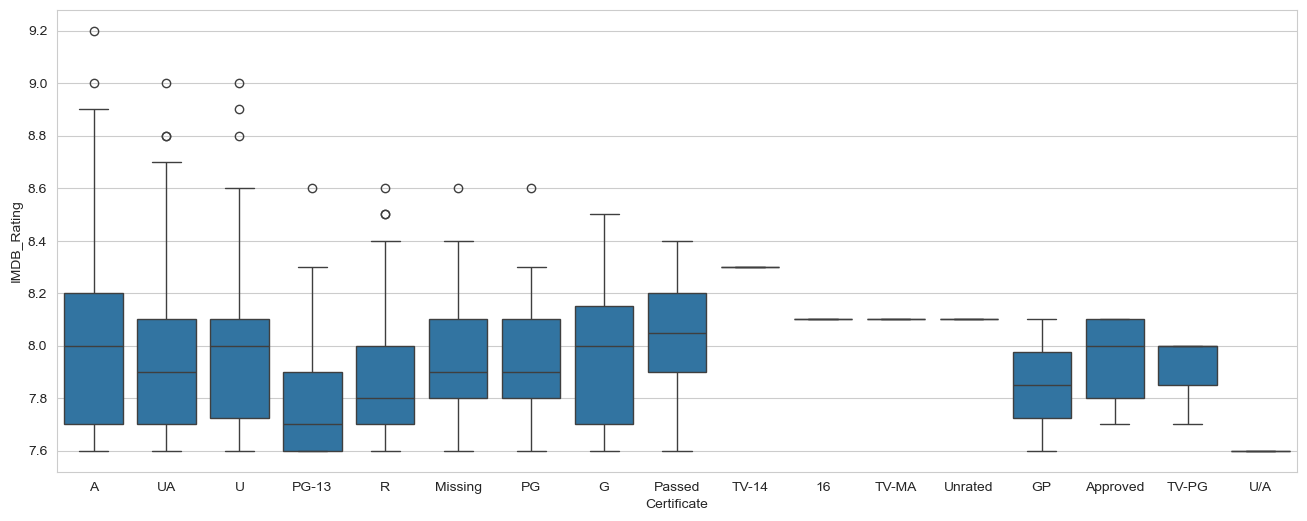

In [52]:
#ALGUNS OUTLIERS, GRANDES VARIAÇÕES POR CLASSIFICAÇÃO E PRINCIPALMENTE !!!REPRESENTATIVIDADE!!! DOS DADOS
sns.boxplot(x='Certificate', y='IMDB_Rating', data=dados)


### Directors cut
---
- **Stanley Kubrick**
  - Uma das medianas mais altas (~8.3–8.4).
  - Baixa dispersão → filmes dele são avaliados de forma **consistentemente alta**.
  
- **Akira Kurosawa e Quentin Tarantino**
  - Também possuem medianas elevadas (~8.2–8.3).
  - Dispersão moderada, sugerindo que seus filmes mantêm **padrão de qualidade estável**.
  
- **Billy Wilder e Martin Scorsese**
  - Medianamente bem avaliados (~8.2).
  - Dispersão relativamente pequena → notas concentradas.

- **Steven Spielberg e Alfred Hitchcock**
  - Maior dispersão nas notas.
  - Spielberg tem alguns filmes muito bem avaliados, mas também títulos com notas mais baixas.
  - Hitchcock apresenta ampla variação, com filmes tanto abaixo de 7.8 quanto próximos de 8.5.

- **David Fincher e Hayao Miyazaki**
  - Medianamente avaliados (~8.0), mas com cauda longa para cima.
  - Indicativo de alguns filmes de destaque, porém também produções medianas.

- **Woody Allen**
  - Apresenta a menor mediana (~7.6).
  - Dispersão pequena, o que indica consistência, mas em patamar **mais baixo em comparação aos demais diretores**.


<Axes: xlabel='Director', ylabel='IMDB_Rating'>

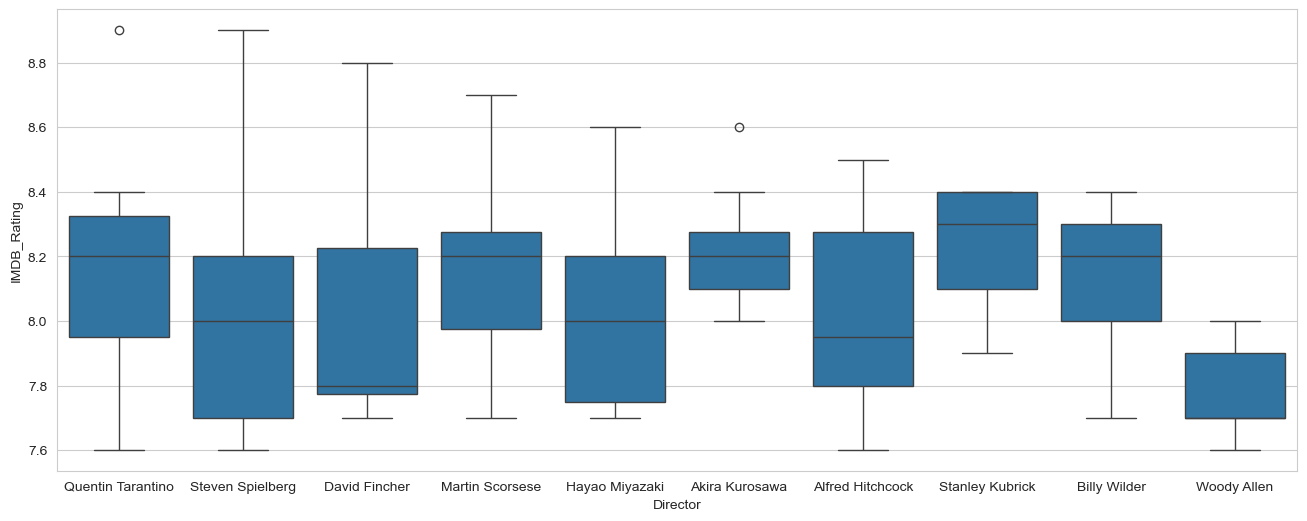

In [54]:
top_directors = dados['Director'].value_counts().head(10).index
sns.boxplot(x='Director', y='IMDB_Rating', data=dados[dados['Director'].isin(top_directors)])


### SEÇÃO TOP 10
---
- Aqui vou buscar observar o TOP10 de varios ambitos
    - Diretores, Gêneros e filmes por Gross, Meta_score e IMDB_Rating.
- Aventure se destaca como genero com maior gross
- Steven spielberg pode se sentir orgulhoso do volume arrecadado.
- Será que muitas pessoas foram para o lado negro da força? Star Wars também lidera no gross.



In [56]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (16,6)

In [57]:
dados_exploded = dados.assign(Genre=dados["Genre"].str.split(","))
dados_exploded = dados_exploded.explode("Genre")
dados_exploded["Genre"] = dados_exploded["Genre"].str.strip()

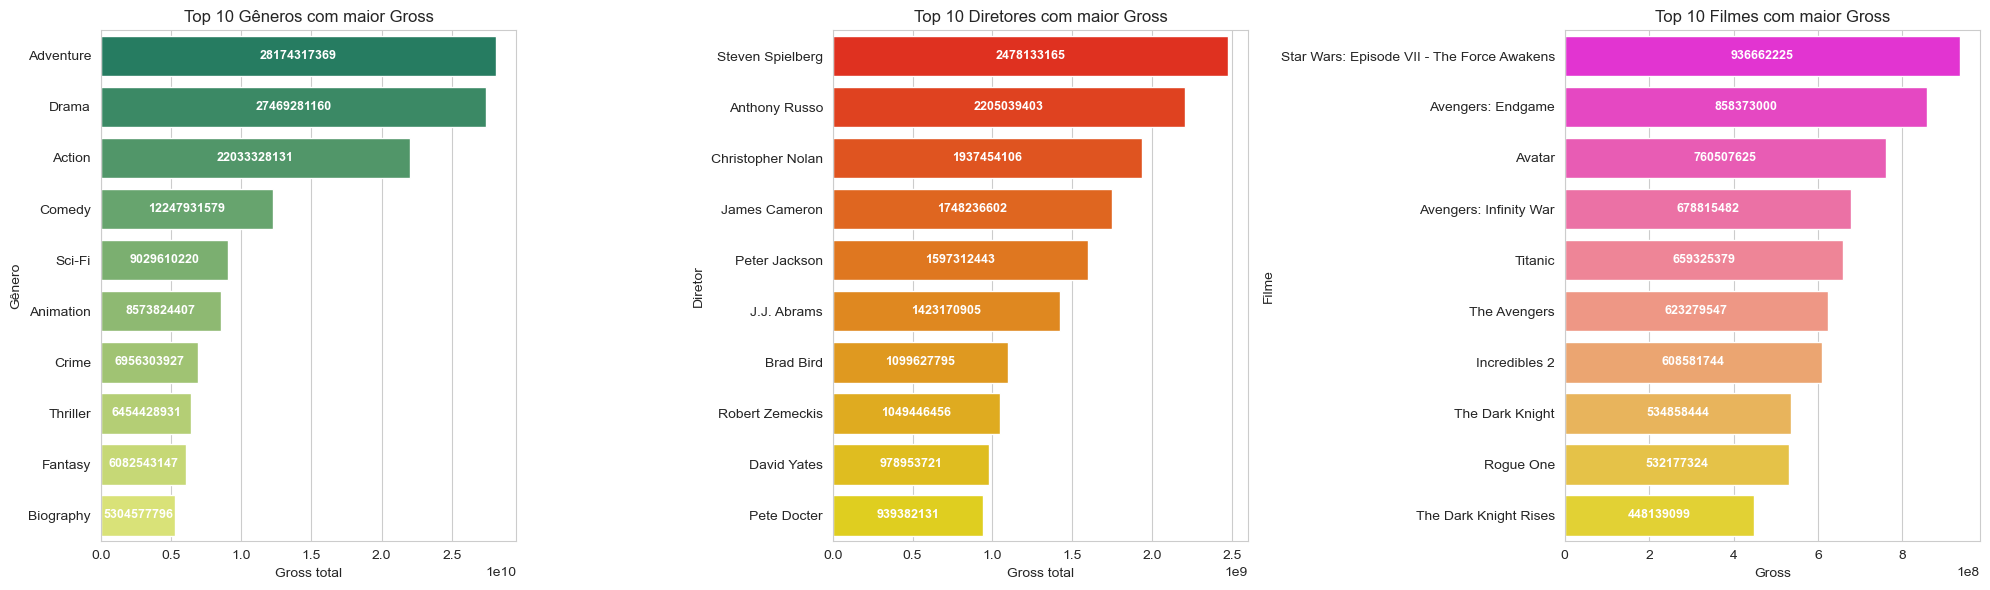

In [58]:
df_gross = dados.dropna(subset=["Gross"])
df_gross_exploded = dados_exploded.dropna(subset=["Gross"])

fig, axes = plt.subplots(1, 3, figsize=(20,6))

#Gêneros
genres_gross = df_gross_exploded.groupby("Genre")["Gross"].sum().sort_values(ascending=False).head(10)
ax = sns.barplot(
    x=genres_gross.values,
    y=genres_gross.index,
    hue=genres_gross.index,
    palette="summer",
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Top 10 Gêneros com maior Gross")
axes[0].set_xlabel("Gross total"); axes[0].set_ylabel("Gênero")
add_labels_inside(ax)

#diretores
directors_gross = df_gross.groupby("Director")["Gross"].sum().sort_values(ascending=False).head(10)
ax = sns.barplot(
    x=directors_gross.values,
    y=directors_gross.index,
    hue=directors_gross.index,
    palette="autumn",
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Top 10 Diretores com maior Gross")
axes[1].set_xlabel("Gross total"); axes[1].set_ylabel("Diretor")
add_labels_inside(ax)

#filmes
top10_gross = df_gross.sort_values("Gross", ascending=False).head(10)
ax = sns.barplot(
    x="Gross",
    y="Series_Title",
    hue="Series_Title",
    data=top10_gross,
    palette="spring",
    legend=False,
    ax=axes[2]
)
axes[2].set_title("Top 10 Filmes com maior Gross")
axes[2].set_xlabel("Gross"); axes[2].set_ylabel("Filme")
add_labels_inside(ax)

plt.tight_layout()
plt.show()

### Top 10 meta_score
---
- Em meta-score Orson Welles lidera entre os diretores, enquanto film-noir entre os generos

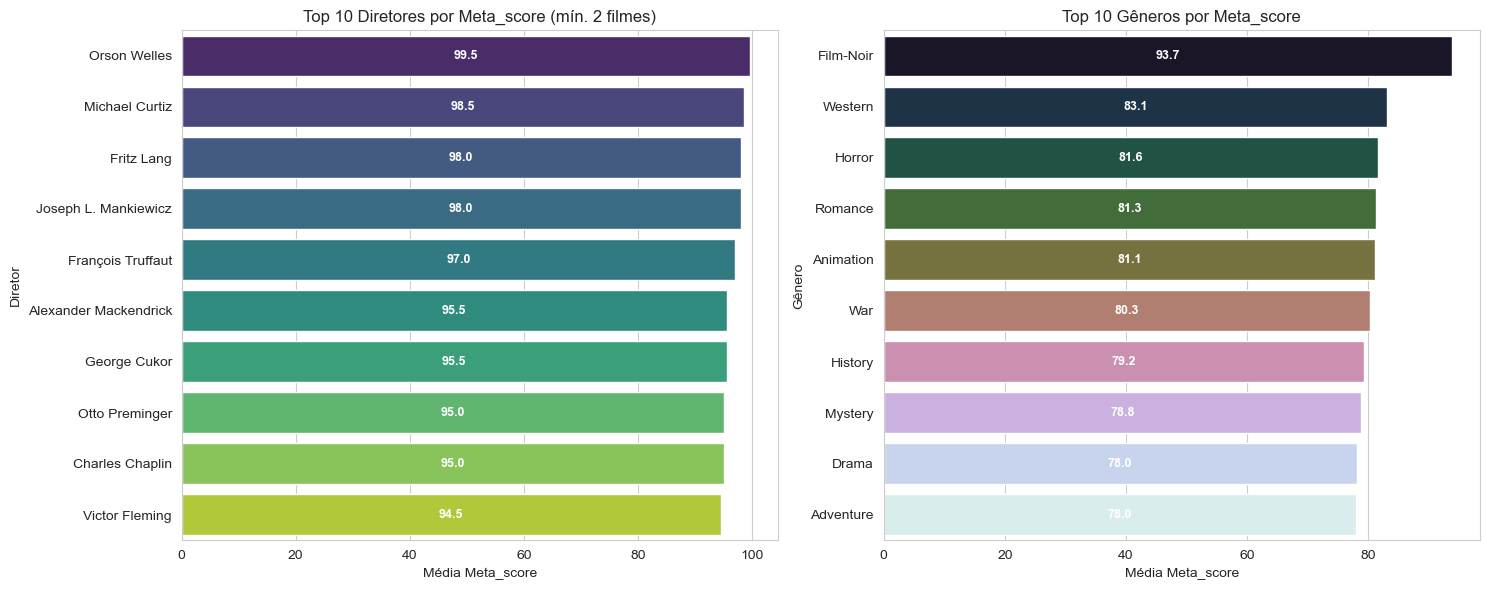

In [103]:

directors_meta = dados.groupby("Director").filter(lambda x: len(x) > 1)
top_directors_meta = directors_meta.groupby("Director")["Meta_score"].mean().dropna().sort_values(ascending=False).head(10)
genres_meta = dados_exploded.groupby("Genre")["Meta_score"].mean().dropna().sort_values(ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(15,6)) 

# Diretores
ax = sns.barplot(x=top_directors_meta.values, y=top_directors_meta.index, hue=top_directors_meta.index, palette="viridis", legend=False, ax=axes[0])
axes[0].set_title("Top 10 Diretores por Meta_score (mín. 2 filmes)")
axes[0].set_xlabel("Média Meta_score"); axes[0].set_ylabel("Diretor")
add_labels_inside(ax, fmt="{:.1f}")

# Gêneros
ax = sns.barplot(x=genres_meta.values, y=genres_meta.index, hue=genres_meta.index, palette="cubehelix", legend=False, ax=axes[1])
axes[1].set_title("Top 10 Gêneros por Meta_score")
axes[1].set_xlabel("Média Meta_score"); axes[1].set_ylabel("Gênero")
add_labels_inside(ax, fmt="{:.1f}")

plt.tight_layout()
plt.show()


In [99]:
#TOP FILMES POR META_SCORE
top_series_meta = dados[["Series_Title", "Meta_score"]].dropna().sort_values(by="Meta_score", ascending=False).head(10)
display(top_series_meta)

,Series_Title,Meta_score
0,The Godfather,100.0
558,Notorious,100.0
118,Vertigo,100.0
123,Citizen Kane,100.0
259,Trois couleurs: Rouge,100.0
273,Fanny och Alexander,100.0
80,Rear Window,100.0
422,Il conformista,100.0
439,Sweet Smell of Success,100.0
49,Casablanca,100.0


### Top 10 por IMBD
---
- Seria legal usar a média por ator pra previsão né? XXXX Não, não seria XXXX Com data leakage todo cuidado é pouco.
- Aqui vamos apenas observar os comportamentos e descobrir um pouco mais sobre artistas diretores e generos.
- Milos Forman se destaca dentre os diretores (Ele dirigiu Amadeus um dos filmes com metascore 100)
- Elijah Wood (Frodo do senhor dos aneis) se destaca entre os atores.
- Filmes de Guerra são os melhores avaliados

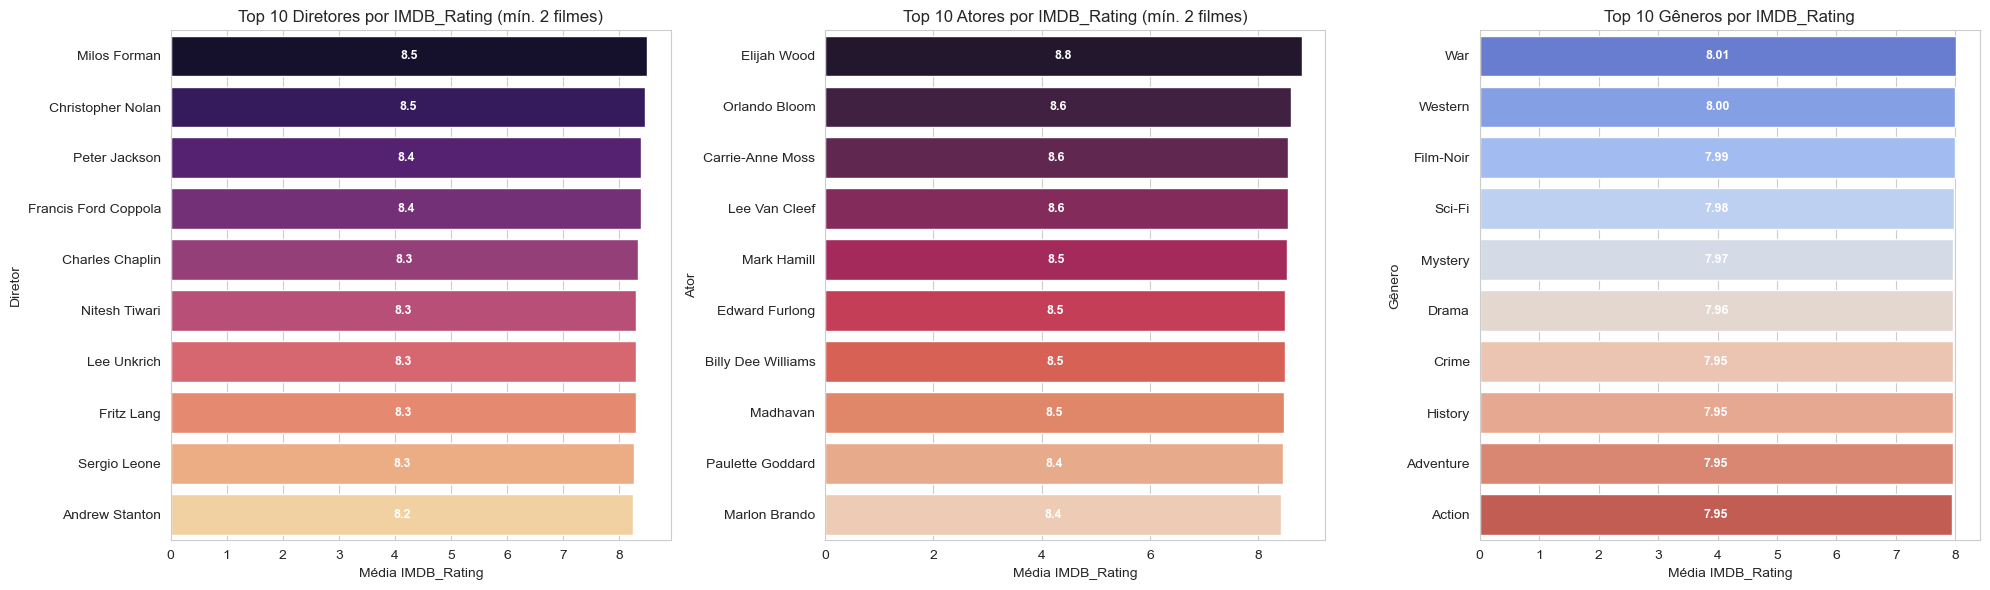

In [105]:
directors_imdb = dados.groupby("Director").filter(lambda x: len(x) > 1)
top_directors_imdb = directors_imdb.groupby("Director")["IMDB_Rating"].mean().sort_values(ascending=False).head(10)
atores_cols = ["Star1", "Star2", "Star3", "Star4"]


actors_imdb = dados.melt(id_vars=["IMDB_Rating"], value_vars=atores_cols, value_name="Actor")
actors_imdb = actors_imdb.groupby("Actor").filter(lambda x: len(x) > 1)
top_actors_imdb = actors_imdb.groupby("Actor")["IMDB_Rating"].mean().sort_values(ascending=False).head(10)

genres_imdb = dados_exploded.groupby("Genre")["IMDB_Rating"].mean().dropna().sort_values(ascending=False).head(10)

fig, axes = plt.subplots(1, 3, figsize=(20,6))

# Diretores
ax = sns.barplot(
    x=top_directors_imdb.values,
    y=top_directors_imdb.index,
    hue=top_directors_imdb.index,
    palette="magma",
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Top 10 Diretores por IMDB_Rating (mín. 2 filmes)")
axes[0].set_xlabel("Média IMDB_Rating"); axes[0].set_ylabel("Diretor")
add_labels_inside(ax, fmt="{:.1f}")

# Atores
ax = sns.barplot(
    x=top_actors_imdb.values,
    y=top_actors_imdb.index,
    hue=top_actors_imdb.index,
    palette="rocket",
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Top 10 Atores por IMDB_Rating (mín. 2 filmes)")
axes[1].set_xlabel("Média IMDB_Rating"); axes[1].set_ylabel("Ator")
add_labels_inside(ax, fmt="{:.1f}")

# Gêneros
ax = sns.barplot(
    x=genres_imdb.values,
    y=genres_imdb.index,
    hue=genres_imdb.index,
    palette="coolwarm",
    legend=False,
    ax=axes[2]
)
axes[2].set_title("Top 10 Gêneros por IMDB_Rating")
axes[2].set_xlabel("Média IMDB_Rating"); axes[2].set_ylabel("Gênero")
add_labels_inside(ax, fmt="{:.2f}")

plt.tight_layout()
plt.show()


In [109]:
dados[dados[atores_cols].eq("Elijah Wood").any(axis=1)]


,Series_Title,Released_Year,Certificate,Runtime_Min,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Decade
4,The Lord of the Rings: The Return of the King,2003,U,201,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.0,2000
9,The Lord of the Rings: The Fellowship of the Ring,2001,U,178,"Action, Adventure, Drama",8.8,A meek Hobbit from the Shire and eight compani...,92.0,Peter Jackson,Elijah Wood,Ian McKellen,Orlando Bloom,Sean Bean,1661481,315544750.0,2000
12,The Lord of the Rings: The Two Towers,2002,UA,179,"Action, Adventure, Drama",8.7,While Frodo and Sam edge closer to Mordor with...,87.0,Peter Jackson,Elijah Wood,Ian McKellen,Viggo Mortensen,Orlando Bloom,1485555,342551365.0,2000


# Para finalizar - Vamos olhar as correlações
---
- Váriaveis de maior correlação com nossa variável alvo seriam boas escolhas para nosso modelo.
- Released Year e No_of_votes estão bem relacionadas com o faturamento

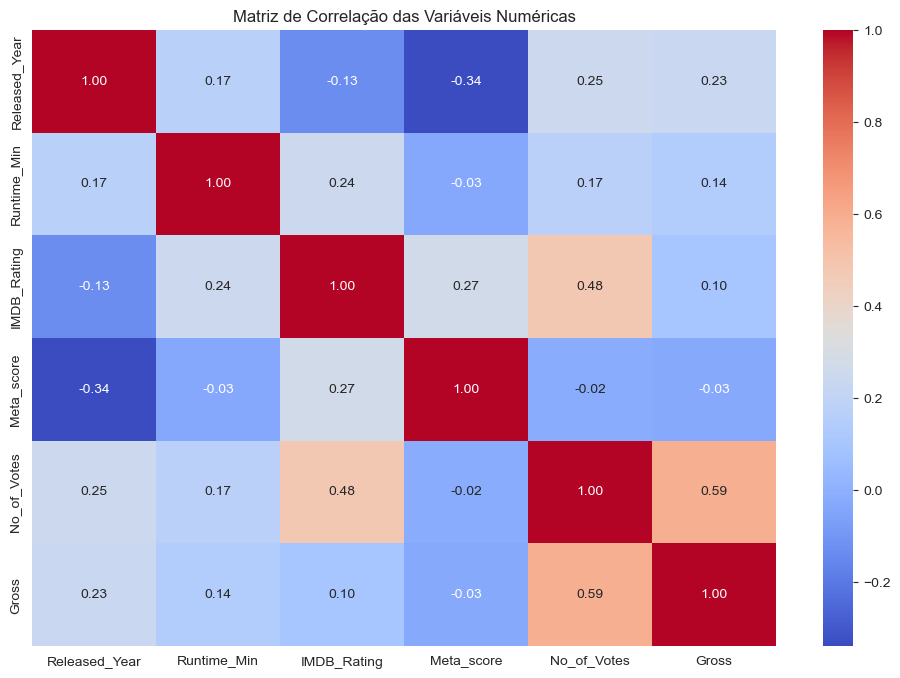

In [72]:

corr_matrix = dados[numericas].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Correlação das Variáveis Numéricas")
plt.show()
